Make the transformation plot

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


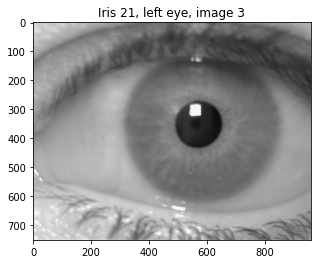

In [137]:
from util import rgbtogray

img_name = "UTIRIS_infrared/021/021_L/Img_021_L_3.bmp"
img = rgbtogray(cv2.imread(img_name).astype(np.double)/255.)
fig, ax = plt.subplots()
ax.imshow(img, cmap="gray", vmin=0., vmax=1.)
ax.set_title("Iris 21, left eye, image 3")
fig.savefig("figures/iris21.png", dpi=400, facecolor="white", edgecolor='none')

In [30]:
from IrisSegmentation import FastIrisPupilScanner
out = FastIrisPupilScanner(img_name)

In [88]:
def transform_cropped_iris_for_plot(img, pup_center, pup_r, iris_center, iris_r, theta_res, rho_res,
                  method = "Daug"):    
    assert(img.ndim == 2)
    if np.max(img) > 1.:
        img = img/255.
    fig, ax = plt.subplots()
    ax.imshow(img, cmap="gray", vmin=0., vmax=1.)

    def to_ind(coords):
        return np.array(np.round(coords), dtype="int32")
    
    def outside(img, pos):
        m, n = np.shape(img)
        coord = to_ind(pos)
        if coord[0] < 0 or coord[1] < 0:
            return True
        elif coord[1] >= m or coord[0] >= n:
            return True
        elif (img[coord[1]][coord[0]] - 1.)**2 < 1e-5:
            return True
        else:
            return False
    
    def find_pos_limbus(img, pos, center):
        v = pos - center
        hi = pos
        lo = center
        u = v/np.linalg.norm(v)
        dr = np.sqrt(2)*1.1 # This (should) ensure boundary point
        is_outside = True
        i = 0
        max_iter = 100
        while is_outside and i < max_iter:
            i += 1
            mid = (hi + lo)*0.5
            if outside(img, mid):
                hi = mid
            elif outside(img, mid + u*dr):
                return mid
            else:
                lo = mid
        
        
    tranf = np.zeros([rho_res, theta_res])
    
    
    if method == "Daug":        
        dtheta = 2*np.pi/theta_res
        thetas = np.arange(0., 2*np.pi, dtheta)
        X = np.zeros([rho_res, len(thetas)])
        Y = np.zeros([rho_res, len(thetas)])
        #assert(np.abs(thetas[-1] - 2.*np.pi) >1e-5)    
        rhos = np.linspace(0., 1., rho_res)
        for j, theta in enumerate(thetas):
            u = np.array([np.cos(theta), np.sin(theta)])
            pos_pup = pup_center + u*pup_r
            
            # There is a high risk that the limbus point is outside of the cropped iris.
            pos_limbus = iris_center + u*iris_r
            if outside(img, pos_limbus):
                pos_limbus = find_pos_limbus(img, pos_limbus, iris_center)
            
            x = (1 - rhos)*pos_pup[0] + rhos*pos_limbus[0]
            y = (1 - rhos)*pos_pup[1] + rhos*pos_limbus[1]
            #ax.plot(x, y, color="red", lw=0.5)
            X[:, j] = x
            Y[:, j] = y
            #tranf[:, j] = img[np.flip(to_ind(y)), to_ind(x)]
            
            tranf[:, j] = img[to_ind(y), to_ind(x)]
        for j in range(len(thetas)):
            x = X[:, j]
            y = Y[:, j]
            ax.plot(x, y, color="blue", lw=0.5)
        for i in range(rho_res):
            x = X[i, :]
            y = Y[i, :]
            # cursed...
            ax.plot(np.concatenate([x, np.array([x[0]])]), np.concatenate([y, np.array([y[0]])]), color="blue", lw=0.5)
            # cursed...
        return tranf, fig, ax



(520.0, 0.0)

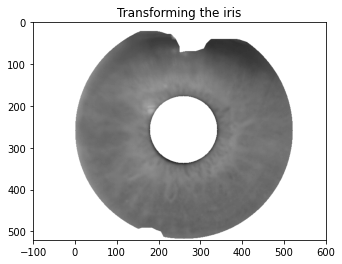

In [89]:
fig, ax = plt.subplots()
ax.imshow(out["iris"]/255, cmap="gray", vmin=0., vmax=1.)
ax.set_title("Transforming the iris")
ax.set_xlim(-100, 600)
ax.set_ylim(520, 0)

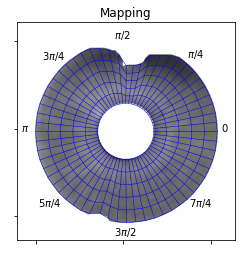

In [138]:
theta_psize = 5
n_theta_patches = 12
rho_psize = 3
n_rho_patches = 2
tranf_img, fig, ax = transform_cropped_iris_for_plot(out['iris']/255, out['pupil_xy'], out['pupil_r'], out['iris_xy'], out['iris_r'], 
                      theta_res = theta_psize*n_theta_patches, rho_res = rho_psize*n_rho_patches,
                      method = "Daug")
figure_hw = 310
txt_hw = 330
pc = out['pupil_xy']
ax.set_xlim(pc[1] - figure_hw, pc[1] + figure_hw)
ax.set_ylim(pc[0] + figure_hw, pc[0] - figure_hw)
angle_str = ["$3\pi/2$", "$7\pi/4$", "$0$", "$\pi/4$", "$\pi/2$", "$ 3 \pi/4$", "$\pi$", "$5\pi/4$"]
adj_left = 35
factors = [0.9, 0.92, 0.93, 0.9, 0.8, 0.88, 0.8, 0.92]
angles = np.repeat(np.pi/4, 8)*np.arange(8)
for s, th, f in zip(angle_str, list(angles), factors):
    u = np.array([np.cos(th), np.sin(th)])
    cords = np.array(np.round(pc + u*txt_hw*f), dtype="int32")
    ax.text(cords[1]-adj_left, cords[0], s)
ax.set_xticks([0, 250, 500])
ax.set_xticklabels([" ", " ", " "])
ax.set_yticks([0, 250, 500])
ax.set_yticklabels([" ", " ", " "])
ax.set_title("Mapping")
fig.savefig("figures/mapping.png", dpi=400, facecolor="white", edgecolor='none')




In [140]:
from util import transform_cropped_iris

theta_psize = 15
n_theta_patches = 16
rho_psize = 15
n_rho_patches = 8
transf_img = transform_cropped_iris(out['iris']/255, out['pupil_xy'], out['pupil_r'], out['iris_xy'], out['iris_r'], 
                      theta_res = theta_psize*n_theta_patches, rho_res = rho_psize*n_rho_patches)

In [142]:
transf_img.shape

(120, 240)

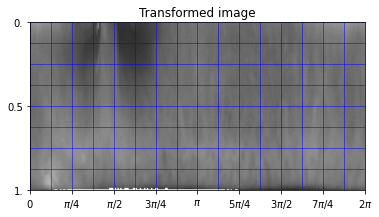

In [168]:
fig, ax = plt.subplots()
cut = 127
rotated = np.concatenate([transf_img[:,cut:], transf_img[:,:cut]], axis = 1)  
ax.imshow(rotated, cmap="gray", vmin=0., vmax=1.)
ax.set_xlim([0, 240])
ax.set_ylim([0, 120])
ax.set_xticks([0, 30, 60, 90, 120, 150, 180, 210, 240])
ax.set_xticklabels(["$0$", "$\pi/4$", "$\pi/2$", "$ 3 \pi/4$", "$\pi$", "$5\pi/4$", "$3\pi/2$", "$7\pi/4$", "$2\pi$"])
ax.set_yticks([120, 60, 0])
ax.set_yticklabels(["0.", "0.5", "1."])
ax.set_title("Transformed image")
for vline in np.arange(0, 240+1, 15):
    ax.vlines(vline, ymin=0, ymax=120, color="blue", lw=0.5)
for hline in np.arange(0, 120+1, 15):
    ax.hlines(hline, xmin=0, xmax=240, color="blue", lw=0.5)
fig.savefig("figures/tranf_img.png", dpi=400, facecolor="white", edgecolor='none')
